In [1]:
import numpy as np
import pandas as pd
import os
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import random
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
augmented_dataset_path = "/kaggle/input/thermal-dataset"
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, txt_file, transform=None):
        """
        Args:
            txt_file (string): Path to the .txt file containing image paths and label IDs.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = []
        with open(txt_file, 'r') as file:
            for line in file:
                image_path , label = line.strip().split("|")
                image_path = image_path.replace("/home/infinity/Documents/PlantVillage-Dataset/raw" , "/content/raw/raw")
                self.data.append((image_path, int(label)))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        # Load image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
from torchvision import transforms
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

dataset = ImageDataset("/content/drive/MyDrive/train.txt", transform=transform)

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Training samples: 298883
Validation samples: 74721


In [7]:
test_dataset = ImageDataset("/content/drive/MyDrive/test.txt", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print(f"Training samples: {len(test_dataset)}")

Training samples: 358955


In [8]:
for images, labels in train_loader:
    print(images.shape, labels)
    break

torch.Size([32, 3, 224, 224]) tensor([33, 11, 33, 32,  3, 15, 24, 31, 31,  3, 14, 28, 35,  8, 15, 32, 11, 32,
        35, 32, 14, 11, 32, 15,  5, 34, 15, 35, 32, 24, 15, 15])


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_ftrs = model.classifier[1].in_features
num_classes = 38
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()


num_epochs = 70
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_acc_history.append(train_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "efficientnet_b0_trained.pth")
print("\nModel saved as efficientnet_b0_trained.pth")


Using device: cuda


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
num_classes = 38
model.fc = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 1
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

torch.save(model.state_dict(), "googlenet_trained.pth")
print("\nModel saved as googlenet_trained.pth")


Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
num_classes = 6
model.fc = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()


num_epochs = 70
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "inception_trained.pth")
print("\nModel saved as inception_trained.pth")


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
num_classes = 38
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)
scaler = torch.amp.GradScaler()

num_epochs = 1
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    print(f"Epoch {epoch+1}/{num_epochs}")
    with tqdm(train_loader, desc="Training", leave=False) as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "Loss": f"{running_loss / (total // labels.size(0)):.4f}",
                "Acc": f"{100 * correct / total:.2f}%"
            })

    print(f"Epoch {epoch+1} completed. Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "vggnet_trained.pth")
print("\nModel saved as vggnet_trained.pth")


Using device: cuda
Epoch 1/1


Epoch 1 completed. Loss: 0.8084, Accuracy: 77.23%

Model saved as vggnet_trained.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
num_classes = 6
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[6].parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)
scaler = torch.amp.GradScaler()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

num_epochs = 70
train_acc_history = []
val_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f"Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "alexnet_trained.pth")
print("\n Model saved as alexnet_trained.pth")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
num_ftrs = model.heads.head.in_features
num_classes = 38
model.heads.head = nn.Linear(num_ftrs, num_classes)

for param in model.encoder.parameters():
    param.requires_grad = False

for param in model.heads.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 1
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False
    ):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_acc_history.append(train_acc)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%"
    )

torch.save(model.state_dict(), "vit_b_16_trained.pth")
print("\nModel saved as vit_b_16_trained.pth")

In [15]:
class_map = {
    0: "Apple___Apple_scab",
    1: "Apple___Black_rot",
    2: "Apple___Cedar_apple_rust",
    3: "Apple___healthy",
    4: "Blueberry___healthy",
    5: "Cherry_(including_sour)___Powdery_mildew",
    6: "Cherry_(including_sour)___healthy",
    7: "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    8: "Corn_(maize)___Common_rust_",
    9: "Corn_(maize)___Northern_Leaf_Blight",
    10: "Corn_(maize)___healthy",
    11: "Grape___Black_rot",
    12: "Grape___Esca_(Black_Measles)",
    13: "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    14: "Grape___healthy",
    15: "Orange___Haunglongbing_(Citrus_greening)",
    16: "Peach___Bacterial_spot",
    17: "Peach___healthy",
    18: "Pepper,_bell___Bacterial_spot",
    19: "Pepper,_bell___healthy",
    20: "Potato___Early_blight",
    21: "Potato___Late_blight",
    22: "Potato___healthy",
    23: "Raspberry___healthy",
    24: "Soybean___healthy",
    25: "Squash___Powdery_mildew",
    26: "Strawberry___Leaf_scorch",
    27: "Strawberry___healthy",
    28: "Tomato___Bacterial_spot",
    29: "Tomato___Early_blight",
    30: "Tomato___Late_blight",
    31: "Tomato___Leaf_Mold",
    32: "Tomato___Septoria_leaf_spot",
    33: "Tomato___Spider_mites Two-spotted_spider_mite",
    34: "Tomato___Target_Spot",
    35: "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    36: "Tomato___Tomato_mosaic_virus",
    37: "Tomato___healthy"
}


In [ ]:
# checkpoint = torch.load("/content/efficientnet_b0_trained.pth")
# model.load_state_dict(checkpoint)

<ipython-input-25-9414d68aa1a3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/efficientnet_b0_trained.pth")


<All keys matched successfully>

In [26]:
import numpy as np
import torch
from tqdm import tqdm

class_names = class_map
num_classes = len(class_names)
def calculate_per_class_accuracy(model, data_loaders, device, datasets=[ "Validation", "Test"]):
    for dataset_type, data_loader in zip(datasets, data_loaders):
        model.eval()
        class_correct = np.zeros(num_classes)
        class_total = np.zeros(num_classes)

        print(f"\nCalculating Per-Class {dataset_type} Accuracy...")
        with torch.no_grad():
            for steps , (images, labels) in tqdm(enumerate(data_loader), desc=f"{dataset_type} Progress", leave=True):
                if steps == 2000:
                  break
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1

        print(f"\nFinal Per-Class {dataset_type} Accuracy:\n")
        for i in range(num_classes):
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f"{class_names[i]}: {dataset_type} Accuracy = {accuracy:.2f}%")
            else:
                print(f"{class_names[i]}: {dataset_type} Accuracy = No samples available")

data_loaders = [val_loader, test_loader]
datasets = [ "Validation", "Test"]
calculate_per_class_accuracy(model, data_loaders, device, datasets=datasets)


Calculating Per-Class Validation Accuracy...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Progress: 2000it [03:09, 10.58it/s]



Final Per-Class Validation Accuracy:

Apple___Apple_scab: Validation Accuracy = 76.70%
Apple___Black_rot: Validation Accuracy = 95.08%
Apple___Cedar_apple_rust: Validation Accuracy = 88.34%
Apple___healthy: Validation Accuracy = 92.18%
Blueberry___healthy: Validation Accuracy = 97.27%
Cherry_(including_sour)___Powdery_mildew: Validation Accuracy = 93.28%
Cherry_(including_sour)___healthy: Validation Accuracy = 98.47%
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: Validation Accuracy = 72.24%
Corn_(maize)___Common_rust_: Validation Accuracy = 99.30%
Corn_(maize)___Northern_Leaf_Blight: Validation Accuracy = 88.51%
Corn_(maize)___healthy: Validation Accuracy = 99.64%
Grape___Black_rot: Validation Accuracy = 88.72%
Grape___Esca_(Black_Measles): Validation Accuracy = 94.43%
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): Validation Accuracy = 96.55%
Grape___healthy: Validation Accuracy = 96.60%
Orange___Haunglongbing_(Citrus_greening): Validation Accuracy = 99.47%
Peach___Bacterial_spot:

Test Progress: 2000it [03:06, 10.71it/s]



Final Per-Class Test Accuracy:

Apple___Apple_scab: Test Accuracy = 85.51%
Apple___Black_rot: Test Accuracy = 97.29%
Apple___Cedar_apple_rust: Test Accuracy = 92.06%
Apple___healthy: Test Accuracy = 94.90%
Blueberry___healthy: Test Accuracy = 99.18%
Cherry_(including_sour)___Powdery_mildew: Test Accuracy = 96.52%
Cherry_(including_sour)___healthy: Test Accuracy = 98.38%
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: Test Accuracy = 75.94%
Corn_(maize)___Common_rust_: Test Accuracy = 98.19%
Corn_(maize)___Northern_Leaf_Blight: Test Accuracy = 84.11%
Corn_(maize)___healthy: Test Accuracy = 99.61%
Grape___Black_rot: Test Accuracy = 95.07%
Grape___Esca_(Black_Measles): Test Accuracy = 96.84%
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): Test Accuracy = 97.32%
Grape___healthy: Test Accuracy = 97.97%
Orange___Haunglongbing_(Citrus_greening): Test Accuracy = 99.53%
Peach___Bacterial_spot: Test Accuracy = 95.52%
Peach___healthy: Test Accuracy = 96.68%
Pepper,_bell___Bacterial_spot: Test Ac

Calculating Test Accuracy:  50%|█████     | 1000/2000 [01:33<01:33, 10.75it/s]


Test Accuracy: 93.00%


Calculating Precision-Recall Data:  50%|█████     | 1000/2000 [01:32<01:32, 10.80it/s]


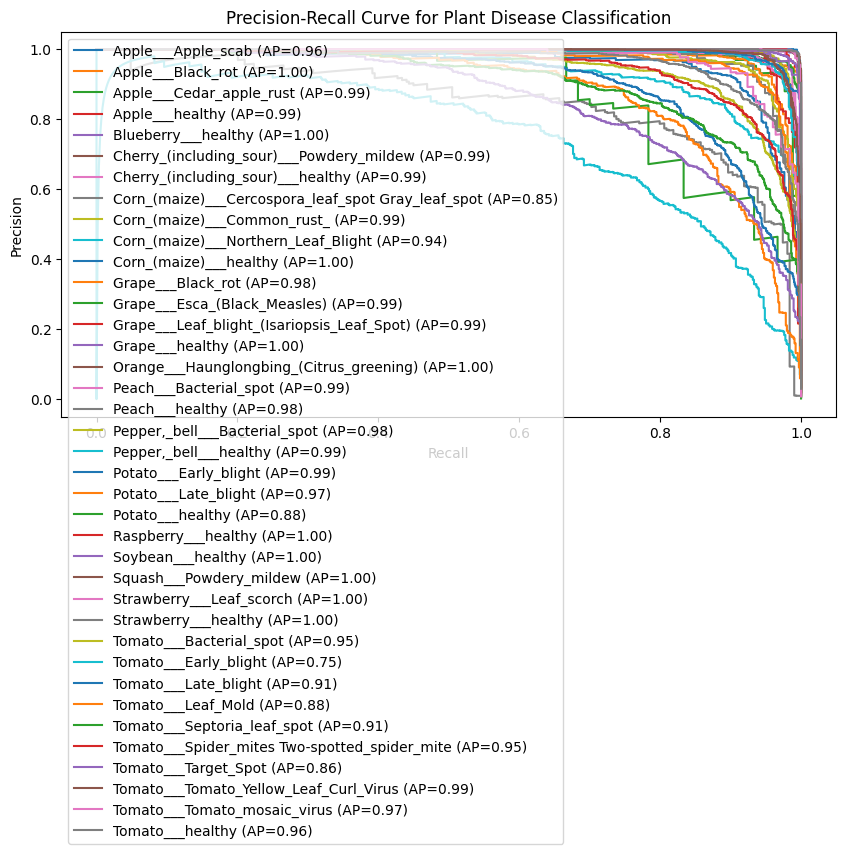

In [27]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm

y_true = []
y_scores = []
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for steps, (images, labels) in enumerate(tqdm(test_loader, desc="Calculating Test Accuracy", total=2000)):
        if steps == 1000:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

with torch.no_grad():
    for steps, (images, labels) in enumerate(tqdm(test_loader, desc="Calculating Precision-Recall Data", total=2000)):
        if steps == 1000:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

plt.figure(figsize=(10, 5))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    avg_precision = average_precision_score(y_true == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Plant Disease Classification")
plt.legend()
plt.show()
